### Towards a Bayesian Network Model for Predicting Flaky Automated Tests

In [ ]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 14.6 MB/s 


In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
# from pgmpy.sampling import GibbsSampling

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
Flakiness_model = BayesianNetwork(
    [
        ("DI", "HTC"),
        ("LTFS", "HTC"),
        ("HAC", "HTC"),
        ("LTMS", "HTC"),
        ("HTC", "TF"), 
        ("ND", "TF"),
        ("EW", "ND"),
        ("CL", "ND"),
        ("IS", "TF"),
        ("IC", "TF"),
                
    ]
)

nodes = list(Flakiness_model.nodes())
edges = list(Flakiness_model.edges())

print('The nodes of the net are: {}'.format(nodes))
print('The edges of the net are: {}'.format(edges))

The nodes of the net are: ['DI', 'HTC', 'LTFS', 'HAC', 'LTMS', 'TF', 'ND', 'EW', 'CL', 'IS', 'IC']
The edges of the net are: [('DI', 'HTC'), ('HTC', 'TF'), ('LTFS', 'HTC'), ('HAC', 'HTC'), ('LTMS', 'HTC'), ('ND', 'TF'), ('EW', 'ND'), ('CL', 'ND'), ('IS', 'TF'), ('IC', 'TF')]


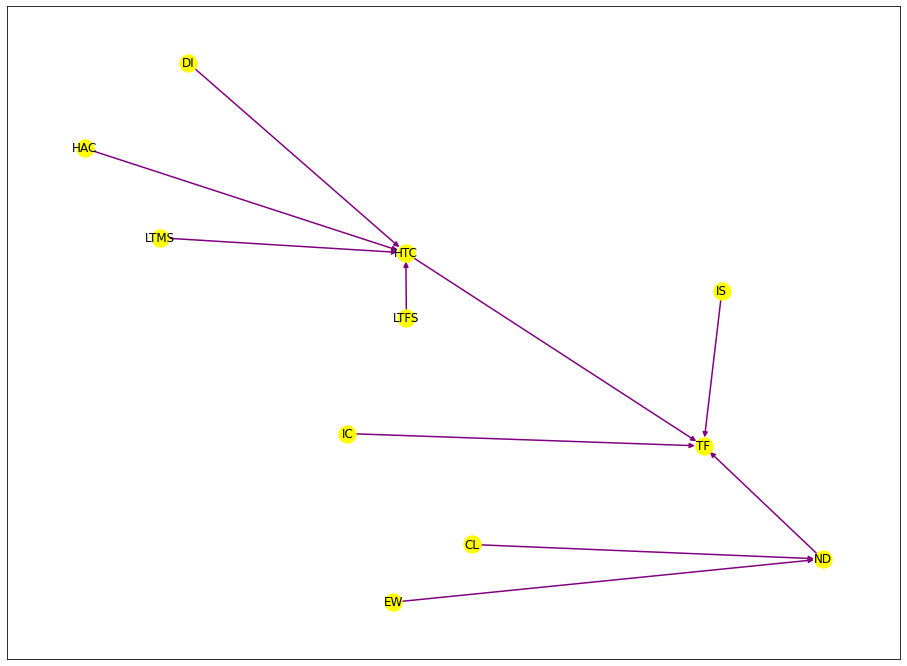

In [ ]:
DAG = nx.DiGraph()
DAG.add_edges_from(edges)

fig = plt.figure(figsize = (16,12))
pos = nx.spring_layout(DAG) 

nx.draw_networkx_nodes(DAG, pos = pos, node_color = 'yellow')
nx.draw_networkx_labels(DAG, pos = pos)
nx.draw_networkx_edges(DAG, pos = pos, edge_color = 'purple', width = 1.5, arrows = True)

plt.show()

![image.png](attachment:image.png)

In [ ]:
cpd_di = TabularCPD(variable="DI", variable_card=2, values=[[0.06], [0.94]])
cpd_ltfs = TabularCPD(variable="LTFS", variable_card=2, values=[[0.8], [0.2]])
cpd_hac = TabularCPD(variable="HAC", variable_card=2, values=[[0.3], [0.7]])
cpd_ltms = TabularCPD(variable="LTMS", variable_card=2, values=[[0.8], [0.2]])
cpd_ew = TabularCPD(variable="EW", variable_card=2, values=[[0.95], [0.05]])
cpd_cl = TabularCPD(variable="CL", variable_card=2, values=[[0.85], [0.15]])
cpd_is = TabularCPD(variable="IS", variable_card=2, values=[[0.98], [0.02]])
cpd_ic = TabularCPD(variable="IC", variable_card=2, values=[[0.1], [0.9]])
cpd_nd = TabularCPD(
    variable="ND",
    variable_card=2,
    values=[[0.99, 0.35, 0.49, 0.15], [0.01, 0.65, 0.51, 0.85]],
    evidence=["EW", "CL"],
    evidence_card=[2, 2],
)
cpd_htc = TabularCPD(
    variable="HTC",
    variable_card=2,
    values=[[0.95, 0.85, 0.85, 0.25, 0.9, 0.24, 0.25, 0.1, 0.88, 0.26, 0.15, 0.11, 0.25, 0.1, 0.1, 0.01 ],
            [0.05, 0.15, 0.15, 0.75, 0.1, 0.76, 0.75, 0.9, 0.12, 0.74, 0.85, 0.89, 0.75, 0.9, 0.9, 0.99]],
    evidence=["DI", "LTFS", "HAC", "LTMS"],
    evidence_card=[2,2,2,2],
)
cpd_tf = TabularCPD(
    variable="TF",
    variable_card=2,
    values=[[0.9, 0.8, 0.75, 0.2, 0.76, 0.17, 0.17, 0.11, 0.77, 0.15, 0.16, 0.11, 0.15, 0.1, 0.1, 0.05], 
            [0.1, 0.2, 0.25, 0.8, 0.24, 0.83, 0.83, 0.89, 0.23, 0.85, 0.84, 0.89, 0.85, 0.9, 0.9, 0.95]],
    evidence=["HTC", "ND", "IC", "IS"],
    evidence_card=[2,2,2,2],
)

print (cpd_di)

print (cpd_htc)
print (cpd_tf)

+-------+------+
| DI(0) | 0.06 |
+-------+------+
| DI(1) | 0.94 |
+-------+------+
+--------+---------+---------+-----+---------+---------+---------+
| DI     | DI(0)   | DI(0)   | ... | DI(1)   | DI(1)   | DI(1)   |
+--------+---------+---------+-----+---------+---------+---------+
| LTFS   | LTFS(0) | LTFS(0) | ... | LTFS(1) | LTFS(1) | LTFS(1) |
+--------+---------+---------+-----+---------+---------+---------+
| HAC    | HAC(0)  | HAC(0)  | ... | HAC(0)  | HAC(1)  | HAC(1)  |
+--------+---------+---------+-----+---------+---------+---------+
| LTMS   | LTMS(0) | LTMS(1) | ... | LTMS(1) | LTMS(0) | LTMS(1) |
+--------+---------+---------+-----+---------+---------+---------+
| HTC(0) | 0.95    | 0.85    | ... | 0.1     | 0.1     | 0.01    |
+--------+---------+---------+-----+---------+---------+---------+
| HTC(1) | 0.05    | 0.15    | ... | 0.9     | 0.9     | 0.99    |
+--------+---------+---------+-----+---------+---------+---------+
+-------+--------+--------+--------+-----+--

In [ ]:
cpds = {}

cpds['DI'] = cpd_di
cpds['LTFS']=cpd_ltfs
cpds['HAC']=cpd_hac
cpds['LTMS']=cpd_ltms
cpds["EW"]=cpd_ew
cpds['CL']=cpd_cl
cpds["IS"]=cpd_is
cpds["IC"]=cpd_ic
cpds["ND"]=cpd_nd
cpds["HTC"]=cpd_htc
cpds["TF"]=cpd_tf

In [ ]:
# Associating the parameters with the model structure.
Flakiness_model.add_cpds(cpd_di, cpd_ltfs, cpd_hac, cpd_ltms, cpd_ew, cpd_cl, cpd_is,cpd_ic, cpd_nd, cpd_htc,cpd_tf )

# Checking if the cpds are valid for the model.
Flakiness_model.check_model()

True

In [ ]:
# Get all model implied independence conditions

Flakiness_model.get_independencies()

(IS ⟂ LTMS, CL, HTC, LTFS, DI, EW, IC, ND, HAC)
(IS ⟂ CL, HTC, LTFS, DI, EW, IC, ND, HAC | LTMS)
(IS ⟂ LTMS, HTC, LTFS, DI, EW, IC, ND, HAC | CL)
(IS ⟂ LTMS, CL, LTFS, DI, EW, IC, ND, HAC | HTC)
(IS ⟂ LTMS, CL, HTC, DI, EW, IC, ND, HAC | LTFS)
(IS ⟂ LTMS, CL, HTC, LTFS, EW, IC, ND, HAC | DI)
(IS ⟂ LTMS, CL, HTC, LTFS, DI, IC, ND, HAC | EW)
(IS ⟂ LTMS, CL, HTC, LTFS, DI, EW, ND, HAC | IC)
(IS ⟂ LTMS, CL, HTC, LTFS, DI, EW, IC, HAC | ND)
(IS ⟂ LTMS, CL, HTC, LTFS, DI, EW, IC, ND | HAC)
(IS ⟂ LTFS, DI, EW, IC, HTC, HAC, ND | LTMS, CL)
(IS ⟂ LTFS, DI, EW, IC, CL, ND, HAC | LTMS, HTC)
(IS ⟂ DI, EW, IC, CL, HTC, HAC, ND | LTFS, LTMS)
(IS ⟂ LTFS, EW, IC, CL, HTC, HAC, ND | LTMS, DI)
(IS ⟂ LTFS, DI, IC, CL, HTC, HAC, ND | LTMS, EW)
(IS ⟂ LTFS, DI, EW, CL, HTC, HAC, ND | LTMS, IC)
(IS ⟂ LTFS, DI, EW, IC, CL, HTC, HAC | LTMS, ND)
(IS ⟂ LTFS, DI, EW, IC, CL, HTC, ND | LTMS, HAC)
(IS ⟂ LTFS, DI, EW, LTMS, ND, IC, HAC | CL, HTC)
(IS ⟂ HAC, DI, EW, LTMS, HTC, IC, ND | LTFS, CL)
(IS ⟂ LTFS, HAC, EW, 

In [ ]:
print('There can be made {} valid independence assertions, with respect to the all possible given evidence.'.format(len(Flakiness_model.get_independencies().get_assertions())), "\n")
independencies = Flakiness_model.get_independencies() 
# print(independencies) # Output is not shown for compactness sake

values = list(cpds.values())
# print(values)
variables=['DI', 'LTFS', 'HAC', 'LTMS', 'EW', 'CL', 'IS', 'IC', 'ND', 'HTC', 'TF']

[Flakiness_model.add_cpds(x) for x in values];

for variable in variables:
    print("The local independencies for \'{}\' are:".format(variable), "\n" ,Flakiness_model.local_independencies(variable), "\n")

There can be made 9016 valid independence assertions, with respect to the all possible given evidence. 

The local independencies for 'DI' are: 
 (DI ⟂ IS, LTMS, CL, LTFS, EW, IC, ND, HAC) 

The local independencies for 'LTFS' are: 
 (LTFS ⟂ IS, LTMS, CL, DI, EW, IC, ND, HAC) 

The local independencies for 'HAC' are: 
 (HAC ⟂ IS, LTMS, CL, LTFS, DI, EW, IC, ND) 

The local independencies for 'LTMS' are: 
 (LTMS ⟂ IS, CL, LTFS, DI, EW, IC, ND, HAC) 

The local independencies for 'EW' are: 
 (EW ⟂ IS, LTMS, CL, HTC, LTFS, DI, IC, HAC) 

The local independencies for 'CL' are: 
 (CL ⟂ IS, LTMS, HTC, LTFS, DI, EW, IC, HAC) 

The local independencies for 'IS' are: 
 (IS ⟂ LTMS, CL, HTC, LTFS, DI, EW, IC, ND, HAC) 

The local independencies for 'IC' are: 
 (IC ⟂ IS, LTMS, CL, HTC, LTFS, DI, EW, ND, HAC) 

The local independencies for 'ND' are: 
 (ND ⟂ LTFS, IS, DI, LTMS, HTC, IC, HAC | CL, EW) 

The local independencies for 'HTC' are: 
 (HTC ⟂ IS, EW, IC, CL, ND | LTFS, LTMS, DI, HAC) 

The l

In [ ]:
Flakiness_model.active_trail_nodes("ND")

{'ND': {'CL', 'EW', 'ND', 'TF'}}

##### Markov Blanket

The node 'DI' has Markov blanket: ['LTMS', 'HTC', 'LTFS', 'HAC'].




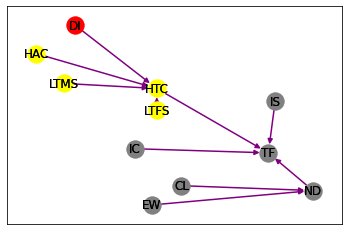



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'HTC' has Markov blanket: ['IS', 'LTMS', 'TF', 'LTFS', 'DI', 'IC', 'ND', 'HAC'].




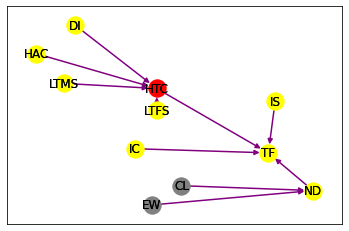



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'LTFS' has Markov blanket: ['LTMS', 'HTC', 'DI', 'HAC'].




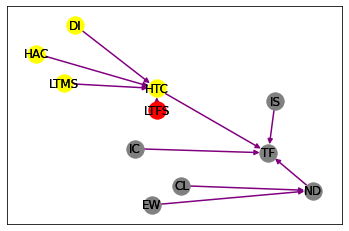



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'HAC' has Markov blanket: ['LTMS', 'HTC', 'LTFS', 'DI'].




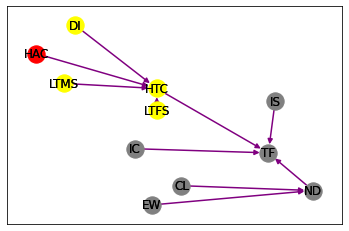



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'LTMS' has Markov blanket: ['HTC', 'LTFS', 'DI', 'HAC'].




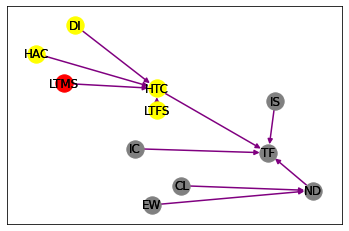



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'ND' has Markov blanket: ['IS', 'CL', 'HTC', 'TF', 'EW', 'IC'].




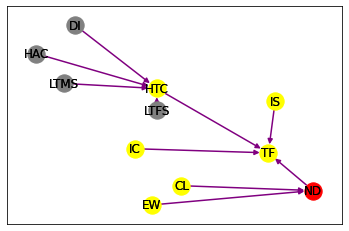



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'EW' has Markov blanket: ['CL', 'ND'].




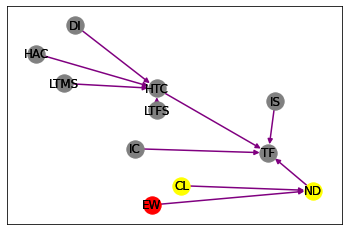



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'CL' has Markov blanket: ['ND', 'EW'].




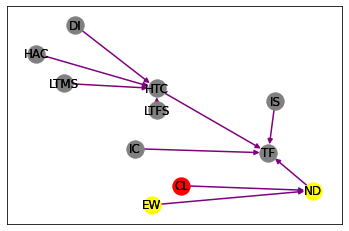



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'IS' has Markov blanket: ['HTC', 'TF', 'IC', 'ND'].




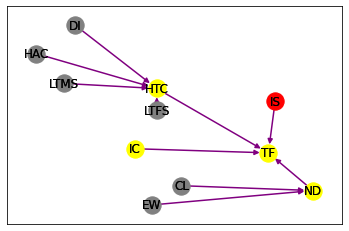



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 

The node 'IC' has Markov blanket: ['IS', 'HTC', 'TF', 'ND'].




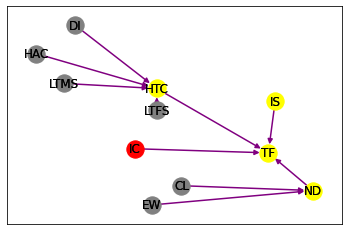



❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈❈ 



In [ ]:
leaves = Flakiness_model.get_leaves()
markov_blanket = {}


for node in nodes:
    if not node in leaves:
        markov_blanket[node] = Flakiness_model.get_markov_blanket(node)
        print('The node \'{}\' has Markov blanket: {}.'.format(node, markov_blanket[node]))
        print('\n')
        
        nx.draw_networkx_nodes(DAG, pos, nodelist = [node], node_color = 'red')
        nx.draw_networkx_nodes(DAG, pos, nodelist = markov_blanket[node], node_color = 'yellow')
        nx.draw_networkx_nodes(DAG, pos, 
               nodelist = [n for n in nodes if n not in markov_blanket[node] and n != node], 
               node_color = 'grey')
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_labels(DAG, pos)
        nx.draw_networkx_edges(DAG, pos, edge_color = 'purple', width = 1.5, arrows = True)
        plt.show()

        print('\n')
        print("❈"*85,"\n")

### Queries 

##### Exact inference with variable elimination

In [ ]:
exact_inference_variable_elimination = VariableElimination(Flakiness_model)

print('P(Test flakiness)')
query1 = exact_inference_variable_elimination.query(['TF'], show_progress = False);
print(query1)

P(Test flakiness)
+-------+-----------+
| TF    |   phi(TF) |
+=======+===========+
| TF(0) |    0.3542 |
+-------+-----------+
| TF(1) |    0.6458 |
+-------+-----------+


In [ ]:
print('P(test flakiness|ND = True, HTC = True)')
query2 = exact_inference_variable_elimination.query(['TF'], {'ND': True, 'HTC': True} , show_progress = False);
print(query2)

P(test flakiness|ND = True, HTC = True)
+-------+-----------+
| TF    |   phi(TF) |
+=======+===========+
| TF(0) |    0.1040 |
+-------+-----------+
| TF(1) |    0.8960 |
+-------+-----------+


In [ ]:
print('P(Non determinism)')
query3 = exact_inference_variable_elimination.query(['ND'], show_progress = False);
print(query3)

P(Non determinism)
+-------+-----------+
| ND    |   phi(ND) |
+=======+===========+
| ND(0) |    0.8712 |
+-------+-----------+
| ND(1) |    0.1288 |
+-------+-----------+


In [ ]:
print('P(Non determinism| TF = True)')
query9 = exact_inference_variable_elimination.query(['ND'],{ 'TF': True}, show_progress = False);
print(query9)

P(Non determinism| TF = True)
+-------+-----------+
| ND    |   phi(ND) |
+=======+===========+
| ND(0) |    0.8290 |
+-------+-----------+
| ND(1) |    0.1710 |
+-------+-----------+


In [ ]:
print('P(HTC)')
query4 = exact_inference_variable_elimination.query(['HTC'], show_progress = False);
print(query4)

P(HTC)
+--------+------------+
| HTC    |   phi(HTC) |
+========+============+
| HTC(0) |     0.3110 |
+--------+------------+
| HTC(1) |     0.6890 |
+--------+------------+


In [ ]:
print('P(HTC|TF= True)')
query5 = exact_inference_variable_elimination.query(['HTC'], { 'TF': True} , show_progress = False);
print(query5)

P(HTC|TF= True)
+--------+------------+
| HTC    |   phi(HTC) |
+========+============+
| HTC(0) |     0.1508 |
+--------+------------+
| HTC(1) |     0.8492 |
+--------+------------+


In [ ]:
print('P(TF|HTC= False, IC=False, ND=False, IS=False)')
query6 = exact_inference_variable_elimination.query(['TF'], { 'HTC': False, 'IC':False, 'ND':False, 'IS':False} , show_progress = False);
print(query6)

P(TF|HTC= False, IC=False, ND=False, IS=False)
+-------+-----------+
| TF    |   phi(TF) |
+=======+===========+
| TF(0) |    0.9000 |
+-------+-----------+
| TF(1) |    0.1000 |
+-------+-----------+


In [ ]:
print('P(TF|HTC= True, IC=True, ND=False, IS=False)')
query8 = exact_inference_variable_elimination.query(['TF'], { 'HTC': True, 'IC':True, 'ND':False, 'IS':False} , show_progress = False);
print(query8)

P(TF|HTC= True, IC=True, ND=False, IS=False)
+-------+-----------+
| TF    |   phi(TF) |
+=======+===========+
| TF(0) |    0.1600 |
+-------+-----------+
| TF(1) |    0.8400 |
+-------+-----------+


In [ ]:
print('P(TF|DI= True, IC=False, EW=True, IS=False)')
query7 = exact_inference_variable_elimination.query(['TF'], { 'DI': True, 'IC':False, 'EW':True, 'IS':False} , show_progress = False);
print(query7)

P(TF|DI= True, IC=False, EW=True, IS=False)
+-------+-----------+
| TF    |   phi(TF) |
+=======+===========+
| TF(0) |    0.5362 |
+-------+-----------+
| TF(1) |    0.4638 |
+-------+-----------+


### Approximate inference

In [ ]:
''' Reference query for comparison'''
reference_query = exact_inference_variable_elimination.query(['TF'], {'ND' : True, 'HTC' : True}, show_progress = False).values[1]
print('P(TF = False|ND = True, HTC = True) = {}.'.format(reference_query))

P(TF = False|ND = True, HTC = True) = 0.896.


In [ ]:
inference = BayesianModelSampling(Flakiness_model)

evidences = [State('ND', True), State('HTC', True)]
verbose = False
sample_size = 10

def prob_LW(samples, variable):
    return round(np.sum(np.dot(samples[variable], samples['_weight']))/np.sum(samples['_weight']), 2)

def relative_error(exact_value, approx_value):
    return np.absolute((exact_value - approx_value)/exact_value)

def absolute_error(exact_value, approx_value):
    return np.absolute(exact_value - approx_value)

def run_experiment(sample_size):
    # Sample
    samples_LW = inference.likelihood_weighted_sample(evidence = evidences, 
                                                      size = sample_size, 
                                                      )
    
    samples_RS = inference.rejection_sample(evidence = evidences, 
                                            size = sample_size, 
                                            )
    
    # Statistics
    query_LW = prob_LW(samples_LW, 'TF')
    query_RS = np.mean(samples_RS['TF'], axis = 0)

      
    # Return results
    return np.array([(sample_size, 
                      query_RS, absolute_error(reference_query, query_RS),
                      query_LW, absolute_error(reference_query, query_LW))],
                    dtype = [('sample_size', '<i8'), 
                             ('query_RS', '<f8'),('e_query_RS', '<f8'),
                             ('query_LW', '<f8'),('e_query_LW', '<f8')])

In [ ]:
results = np.array([], dtype = [('sample_size', '<i8'), 
                                ('query_RS', '<f8'), ('e_query_RS', '<f8'),
                                ('query_LW', '<f8'), ('e_query_LW', '<f8')])

starting_size_ = 1 
final_size = 5    
experiments = 10

for size in np.logspace(starting_size_, final_size, num = experiments, dtype = '<i8'):
    results = np.append(results, run_experiment(size))
    
print(results)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1668 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4641 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12915 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/35938 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

[(    10, 0.7       , 1.96000000e-01, 1.  , 0.104)
 (    27, 0.81481481, 8.11851852e-02, 0.98, 0.084)
 (    77, 0.8961039 , 1.03896104e-04, 0.71, 0.186)
 (   215, 0.91162791, 1.56279070e-02, 0.98, 0.084)
 (   599, 0.88981636, 6.18363940e-03, 0.84, 0.056)
 (  1668, 0.89748201, 1.48201439e-03, 0.89, 0.006)
 (  4641, 0.89937513, 3.37513467e-03, 0.88, 0.016)
 ( 12915, 0.89454123, 1.45876887e-03, 0.9 , 0.004)
 ( 35938, 0.89601536, 1.53597863e-05, 0.89, 0.006)
 (100000, 0.89755   , 1.55000000e-03, 0.9 , 0.004)]


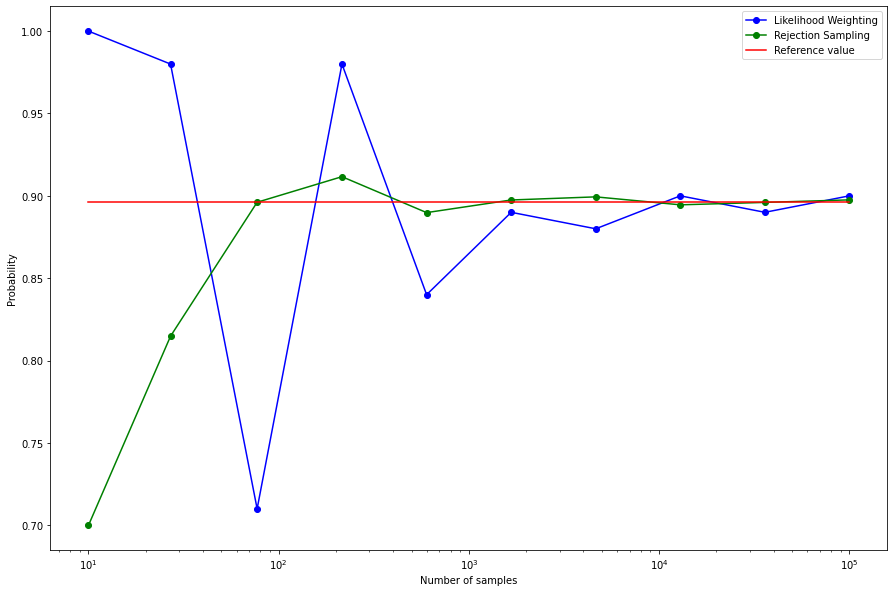

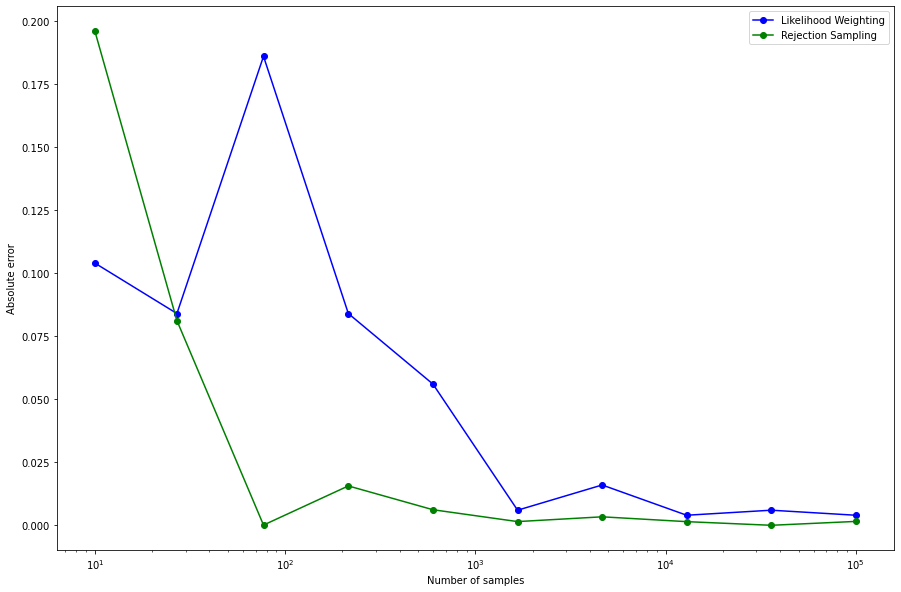

In [ ]:
''' Comparison '''
plt.figure(figsize = (15, 10))
# Plot 1

plt.xlabel("Number of samples")
plt.ylabel("Probability")
#plt.title(f'P({'TF'} | {'ND'} = True, {'HTC'} = True)')
LWCplot, = plt.semilogx(results['sample_size'],
                        results['query_LW'],
                        '-bo',
                        label = "Likelihood Weighting")

RSCplot, = plt.semilogx(results['sample_size'],
                        results['query_RS'],
                        '-go',
                        label = "Rejection Sampling")

VECplot, = plt.semilogx(results['sample_size'],
                        reference_query*np.ones(results.size),
                        'r',
                        label = "Reference value")

plt.legend(handles = [LWCplot, RSCplot, VECplot])

plt.show()
# Plot 2
plt.figure(figsize = (15, 10))

plt.xlabel("Number of samples")
plt.ylabel("Absolute error")
#plt.title(f'Absolute error on P({'TF'} | {'ND'} = True, {'HTC'} = True)')
ELWCplot, = plt.semilogx(results['sample_size'],
                         results['e_query_LW'],
                         'bo-',
                         label = "Likelihood Weighting")

ERSCplot, = plt.semilogx(results['sample_size'],
                         results['e_query_RS'],
                         'go-',
                         label = "Rejection Sampling")

plt.legend(handles = [ELWCplot, ERSCplot])

plt.show()